In [1]:
import torch

import matplotlib.pyplot as plt
import torch.nn.functional as f

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from utils.model_util import *
from utils.data_util import *
from utils.lib_util import *
from utils.train_util import *

plt.style.use('default')

class DistillKL(torch.nn.Module):
    '''
    distilling loss
    '''

    def __init__(self, T, alpha):
        super(DistillKL, self).__init__()
        self.T = T
        self.alpha = alpha

    def forward(self, output, target, logits_teacher):
        prob_teacher = f.softmax(logits_teacher/self.T, dim=1)
        prob_student = f.softmax(output/self.T, dim=1)
        soft_loss = f.kl_div(prob_student, prob_teacher, reduction='batchmean')
        hard_loss = f.cross_entropy(output, target)
        loss = self.alpha * hard_loss + \
            (1 - self.alpha) * soft_loss * self.T**2 / logits_teacher.shape[0]
        return loss

In [2]:
device = 'cuda'
train_data = MNIST(
    root='./data/raw-data/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=False)
test_data = MNIST(
    root='./data/raw-data/',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False)
epochs = 10

In [18]:
teacher_model = LeNet5(28, 28, 1, 10).train().cuda()
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=200,
    shuffle=True)
optimizer = torch.optim.Adam(teacher_model.parameters())
# loss_func = DistillKL(T=4, alpha=0.5)
loss_func = f.cross_entropy
for epoch in range(epochs):
    for data, target in test_dataloader:
        optimizer.zero_grad()
        output = teacher_model(data.to(device))
        loss = loss_func(output, target.to(device))
        loss.backward()
        optimizer.step()
teacher_model.eval()

LeNet5(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (full_con): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
  )
  (output): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
trained_model = LeNet5(28, 28, 1, 10).train().cuda()
loss_ = []
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=200,
    shuffle=True)
optimizer = torch.optim.Adam(trained_model.parameters())
loss_func = DistillKL(T=4, alpha=0.5)
# loss_func = f.cross_entropy
for epoch in range(epochs):
    for data_, target in train_dataloader:
        data = data_.to(device)
        optimizer.zero_grad()
        output = trained_model(data)
        logits = teacher_model(data)
        loss = loss_func(output, target.to(device), logits)
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
print(loss_)

[1.0901870727539062, 1.092010259628296, 1.0908863544464111, 1.0904079675674438, 1.0875412225723267, 1.0848037004470825, 1.0862493515014648, 1.0859313011169434, 1.0847370624542236, 1.083059549331665, 1.0801492929458618, 1.078052282333374, 1.0733511447906494, 1.0736714601516724, 1.070242166519165, 1.0663704872131348, 1.0620287656784058, 1.0624911785125732, 1.050825595855713, 1.0484203100204468, 1.038960576057434, 1.0266377925872803, 1.0233585834503174, 1.0097631216049194, 0.9886811375617981, 0.985964834690094, 0.9708917140960693, 0.9340451955795288, 0.9360131025314331, 0.9027765989303589, 0.8434169292449951, 0.8766030669212341, 0.8252686262130737, 0.8171379566192627, 0.7107989192008972, 0.6898961663246155, 0.7038400769233704, 0.6371238231658936, 0.6857401132583618, 0.5565521121025085, 0.5704587697982788, 0.49513334035873413, 0.4890832006931305, 0.4268103539943695, 0.4379653036594391, 0.40266549587249756, 0.4237934947013855, 0.33569055795669556, 0.4223085045814514, 0.35944122076034546, 0.

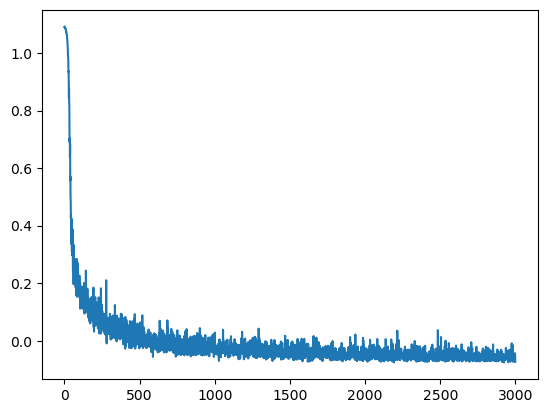

In [22]:
plt.plot(loss_)
plt.show()

In [44]:
import torch

a = torch.tensor([1, 2, 3]).float()
b = torch.tensor([1, 2, 3]).float()
print(a)
print(torch.nn.functional.kl_div(torch.log_softmax(a, dim=-1), torch.softmax(b, dim=0), reduction='batchmean'))

tensor([1., 2., 3.])
tensor(-9.9341e-09)


In [46]:
for data, target in train_dataloader:
    print(type(data), data.shape)
    break

<class 'torch.Tensor'> torch.Size([200, 1, 28, 28])
